In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gc_turbulence as g

%matplotlib inline

/nfs/see-fs-02_users/eeaol/src/anaconda/envs/thesis/lib/python2.7/site-packages/matplotlib/__init__.py:1312: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Removing waves from lab data
----------------------------

Lab data contain waves, which are complicating the frequency
analysis of the turbulence.

Assume that these waves are linear and superpose onto the velocity
data. Then if we can isolate the wave signal we can subtract it from
the data and recover wave free data.

What do the waves look like?

In [2]:
index = 'r14_01_14a'
cache_path = g.default_processed + index + '.hdf5'
r = g.ProcessedRun(cache_path=cache_path)

u_levels = np.linspace(*np.percentile(r.Uf[...], (1, 99)), num=100)

tf = r.Tf[:, 0, :]
zf = r.Zf[:, 0, :]

As we might expect, there are no waves in the mean front relative data:

<matplotlib.contour.QuadContourSet instance at 0x2adfab9abe18>

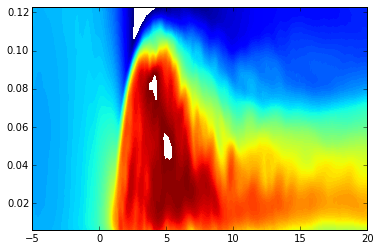

In [8]:
mean = np.mean(r.Uf[...], axis=1)
plt.contourf(tf, zf, mean, levels=u_levels)

If we subtract the mean from the data and look at a single vertical
slice we can see waves:

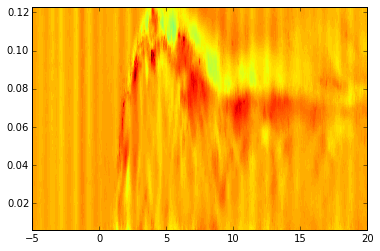

In [9]:
mean_subtracted = r.Uf[...] - mean[..., None, ...]
c = plt.contourf(tf, zf, mean_subtracted[:, 30, :], 100)

We can see that the waves are present throughout the data. In the
non turbulent region outside of the current we can see them quite
well:

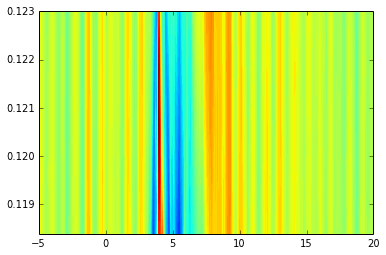

In [39]:
c = plt.contourf(tf[-5:], zf[-5:], mean_subtracted[-5:, 30, :], 100)
wave_levels = c.levels

<matplotlib.contour.QuadContourSet instance at 0x2b2a5f4c9638>

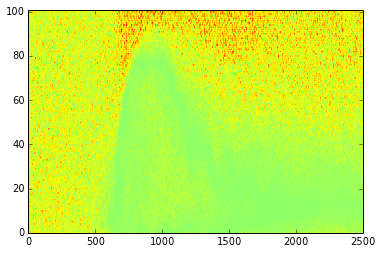

In [40]:
mean_mean = np.mean(mean_subtracted, axis=1)
plt.contourf(mean_mean, 100)

<matplotlib.contour.QuadContourSet instance at 0x2b2b746cf7e8>

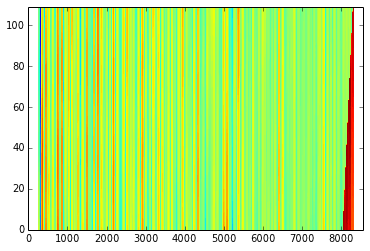

In [50]:
plt.contourf(new_waves[0, :, :], 100)

Plotting in the lab frame shows that these waves are fast (nearly
vertical in $(t, x)$):

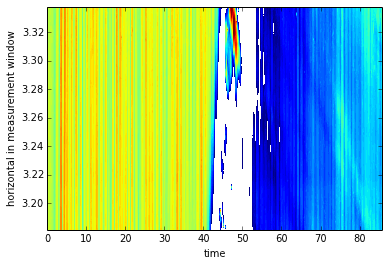

In [6]:
x = r.X[0, :, :]
t = r.T[0, :, :]
plt.contourf(t, x, np.mean(r.U[-10:, :, :], axis=0), levels=wave_levels)
plt.xlabel('time')
plt.ylabel('horizontal in measurement window')

This suggests a means of extracting the wave signal. Transform the
data to the front relative system and take the mean of the current
velocity; subtract this from the data and transform back to the lab
relative system; then average in the vertical and horizontal to
obtain the wave signal.

We can then subtract this from the velocity data and obtain non wavy
velocities.

We need to modify the front transform routines a bit:

In [12]:
r.dt = 0.01
r.ft = r.ft[...]
transformer = g.turbulence.FrontTransformer(r)

uf = transformer.to_front(r.U, order=0)

# compute mean from uf
mean_uf = np.mean(uf, axis=1, keepdims=True)
# expand mean over all x
full_mean_uf = np.repeat(mean_uf, uf.shape[1], axis=1)
# transform to lab frame
trans_mean_uf = transformer.to_lab(full_mean_uf, order=0)
# subtract mean current from lab frame
mean_sub_u = r.U[...] - trans_mean_uf

# from which we might be able to get the wave signal,
# using the fact that it is homogeneous in x and z in the lab frame
waves_xz = np.mean(np.mean(mean_sub_u, axis=0, keepdims=True), axis=0, keepdims=True)

In [41]:
np.linspace(*np.percentile(mean_sub_u, (1, 99)), num=100)

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan])

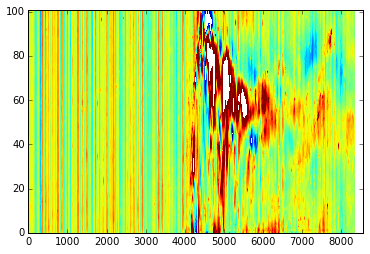

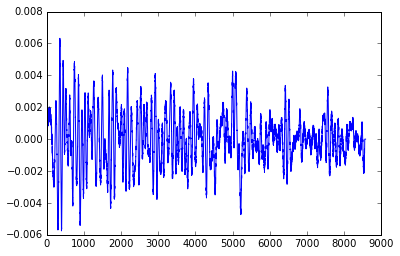

In [66]:
plt.contourf(mean_sub_u[:, 10], levels=np.linspace(*np.nanpercentile(mean_sub_u, (1, 99)), num=100))

plt.figure()
signal = np.nanmean(np.nanmean(mean_sub_u[:, :-10], axis=0), axis=0)
#signal[np.isnan(signal)] = 0
plt.plot(signal)

In [64]:
s = mean_sub_u[0, 0]
s[np.isnan(s)] = 0

from sklearn.decomposition import FastICA

ica = FastICA(n_components=2)

ica.fit_transform(s[None].T)

n_components is too large: it will be set to 1


ValueError: array must not contain infs or NaNs

<matplotlib.contour.QuadContourSet instance at 0x2ae0b2778878>

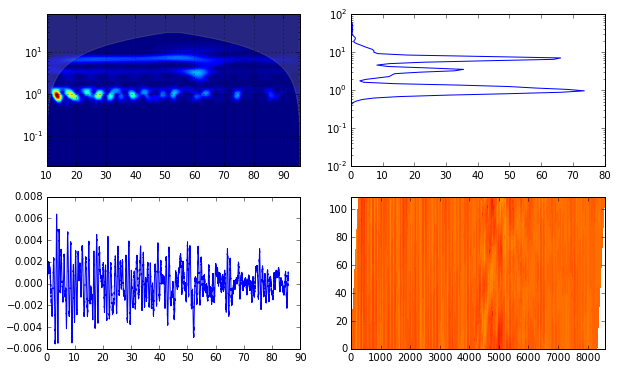

In [55]:
import wavelets
wt = wavelets.WaveletTransform(signal, dt=0.01, time=r.T[0, 0] + 10, wavelet=wavelets.Morlet())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

wt.plot_power(axes[0,0])

axes[0, 1].semilogy(wt.global_wavelet_spectrum, wt.scales)
axes[1, 0].plot(r.T[0, 0], signal)
axes[1, 1].contourf(mean_sub_u.mean(axis=0), levels=u_levels)

<matplotlib.contour.QuadContourSet instance at 0x2ae070403a70>

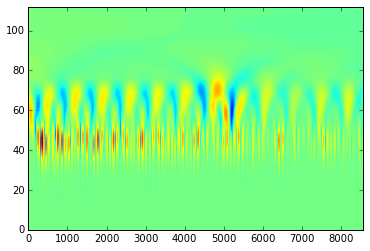

In [54]:
plt.contourf(wt.wavelet_transform.real, 100)

<matplotlib.contour.QuadContourSet instance at 0x2b2a5d2cd998>

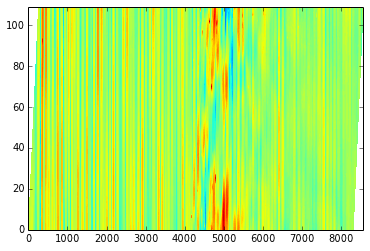

In [14]:
plt.contourf(waves_xz[0], 100)

Looking at this signal, it seems that the waves might be fast rather
than stationary. Is there a wave frame? What speed should these
waves have?

<matplotlib.contour.QuadContourSet instance at 0x2b2a96bbdc68>

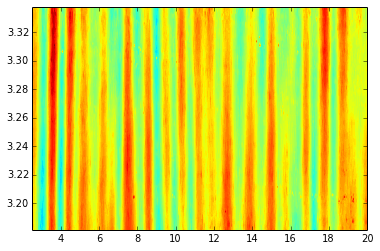

In [15]:
sub = np.s_[20, :, 250: 2000]
plt.contourf(r.T[sub], r.X[sub], mean_sub_u[sub], 100)

When we look closer we can see that these are surface waves in deep
water. Deep water waves have phase velocity varying with wavelength
and here we have a range of wavelengths and speeds. Our method has
largely worked because surface waves are *fast*, with almost
vertical trajectories in (t, x) allowing us to average over x.

Strictly we cannot average over x, only over z. If we do this, we
gain information about the wave trajectories at the expense of noise
coming from the current.

Comparison:

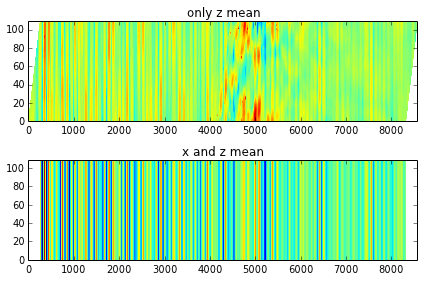

In [29]:
waves_z = np.mean(mean_sub_u, axis=0, keepdims=True)
full_waves_xz = np.repeat(waves_xz, waves_z.shape[1], axis=1)

fig, axes = plt.subplots(nrows=2)
axes[0].contourf(waves_z[0], 100)
axes[0].set_title('only z mean')
axes[1].contourf(full_waves_xz[0], 100)
axes[1].set_title('x and z mean')
fig.tight_layout()

The 'noise' coming from the current is any process that is happening
on a scale that is longer than the time that we observe the current
for, e.g. a slow overturning eddy. We are making the assumption that
the mean subtracted structure averages to zero over time. This is
likely true for small eddies but may fail at larger scales.

For example, the head of the current could shed vortices that
propagate backwards relative to the head. These will show up in the
mean subtracted field. Large structures may not be averaged out over
z and will show up as a propagating feature in (t, x). Averaging
over x will reduce the signature of this sort of structure.

Another limit in this approach is the assumption of linear
superposition. When linear waves collide, the result is easily
obtained as the addition of the waves. This is generally not the
case with non-linear waves. For example, KdV solitons combine in a
manner more like particles colliding - they can not be modelled by
simply adding them together. More exotic solitons might have phase
changes on colliding, e.g. in the BDO model.

The surface waves here are very linear looking, however the gravity
current is decidedly non-linear in character. It is not clear at all
that we can combine the two by addition. That said, assuming linear
superposition is a good first approximation.

When we subtract the waves from the velocity pattern we get a
cleaner looking structure:

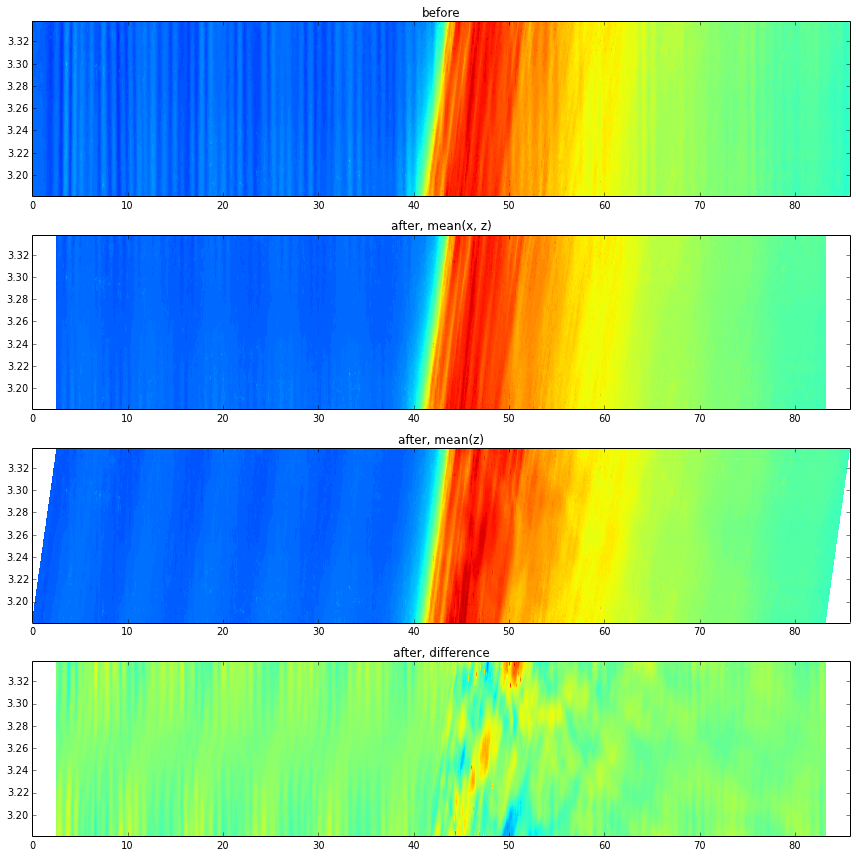

In [32]:
ix = 10
u_levels = np.linspace(-0.03, 0.1, 100)
fig, axes = plt.subplots(nrows=4, figsize=(12, 12))
axes[0].set_title('before')
axes[0].contourf(r.T[ix], r.X[ix], r.U[ix], levels=u_levels)
axes[1].set_title('after, mean(x, z)')
axes[1].contourf(r.T[ix], r.X[ix], (r.U - waves_xz)[ix], levels=u_levels)
axes[2].set_title('after, mean(z)')
axes[2].contourf(r.T[ix], r.X[ix], (r.U - waves_z)[ix], levels=u_levels)
axes[3].set_title('after, difference')
axes[3].contourf(r.T[ix], r.X[ix], (waves_xz - waves_z)[0], levels=np.linspace(-0.015, 0.015, 100))
fig.tight_layout()

The improvement in data clarity is significant regardless of the
averaging used.

Something to check is whether the wave pattern varies run to run.
The wave speeds will vary with the reduced gravity on the surface.

How do we decide which mean to take? It isn't clear - they both have
advantages.

We could use both averaging methods, with multiple transforms
between frames. Method:

1. Compute mean from Uf and subtract

2. Transform mean subtracted Uf to LAB frame

3. Compute wave field as mean(x, z)

4. Subtract wave field from mean subtracted Uf -> varying-current

5. Transform varying-current back to FRONT frame

6. Subtract from mean subtracted Uf

7. Transform back to LAB frame

8. Compute final wave field as mean(z)

XXX: this doesn't really make sense does it?
It sort of does - the basic idea is to use the fact that the waves
are homogeneous in z and nearly homogeneous in x, combined with the
current being nearly statistically homogeneous in x when we
transform to the front frame. The implementation below gets it:

In [ ]:
uf = transformer.to_front(r.U, order=0)

# compute mean from uf
mean_uf = np.mean(uf, axis=1, keepdims=True)
# expand mean over all x
full_mean_uf = np.repeat(mean_uf, uf.shape[1], axis=1)
# transform to lab frame
trans_mean_uf = transformer.to_lab(full_mean_uf, order=0)
# subtract mean current from lab frame
mean_sub_u = r.U[...] - trans_mean_uf

# compute wave field as mean(x, z)
waves_xz = np.mean(np.mean(mean_sub_u, axis=0, keepdims=True), axis=1, keepdims=True)
waves_z = np.mean(mean_sub_u, axis=0, keepdims=True)

In [34]:
# subtract wave field from mean subtracted u to find the current
# signal that is not captured by the mean that varies in x
varying_current = mean_sub_u - waves_xz

# transform varying current back to front frame
trans_varying_current = transformer.to_front(varying_current, order=0)

# subtract the varying current from the velocity
# and compute a new mean
new_mean = np.mean(uf - trans_varying_current, axis=1, keepdims=True)
full_new_mean = np.repeat(new_mean, uf.shape[1], axis=1)
trans_new_mean = transformer.to_lab(full_new_mean, order=0)
trans_new_mean[np.isnan(trans_new_mean)] = 0

# subtract transformed mean from u
new_mean_sub_u = r.U[...] - trans_new_mean - varying_current

# compute new waves
new_waves = np.mean(new_mean_sub_u, axis=0, keepdims=True)

# hmmmm.... some sort of mean signal left in the waves - we don't
# want to be subtracting this.

example plots:

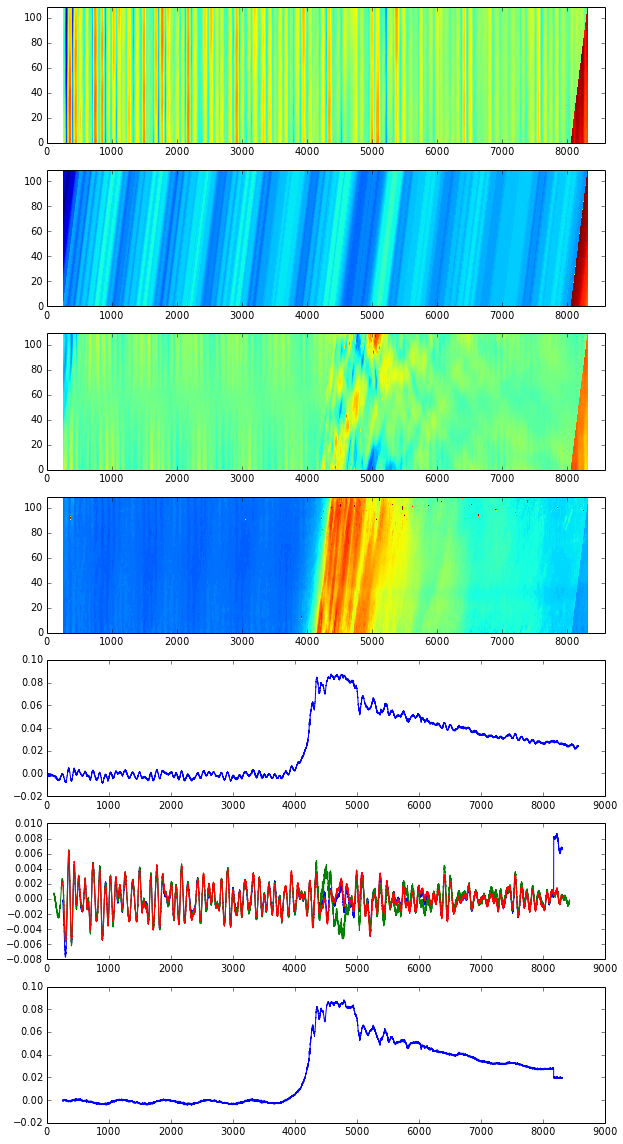

In [55]:
fig, axes = plt.subplots(nrows=7, figsize=(10, 20))
axes[0].contourf(new_waves[0], 100)
axes[1].contourf(new_waves[0] - waves_xz[0], 100)
axes[2].contourf(new_waves[0] - waves_z[0], 100)
axes[3].contourf((r.U - new_waves)[0], levels=u_levels)
ex = np.s_[20, 50, :]
axes[4].plot(r.U[ex])
axes[5].plot(new_waves[0, 50])
axes[5].plot(waves_z[0, 50])
axes[5].plot(waves_xz[0, 0])
axes[6].plot(r.U[ex] - new_waves[0, 50])

In [ ]:
## WHAT ABOUT THE BIG WAVES??

u_n = r.U - new_waves
uf_n = transformer.to_front(u_n, order=0) 
mean_sub_uf_n = uf_n - np.mean(uf_n, axis=1, keepdims=True)
mean_sub_u_n = transformer.to_lab(mean_sub_uf_n, order=0)

<matplotlib.contour.QuadContourSet instance at 0x2a369c68>

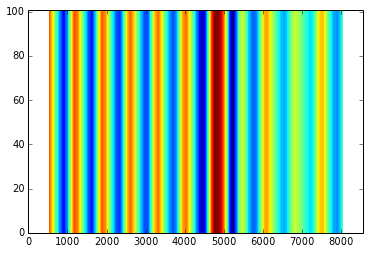

In [84]:
#plt.contourf(np.mean(mean_sub_u_n, axis=1), 100)
#plt.contourf(np.mean(mean_sub_u_n, axis=1) - np.mean(varying_current, axis=1), 100)
#plt.contourf(np.mean(varying_current, axis=1), 100)
more_waves = np.mean(mean_sub_u_n, axis=1, keepdims=True) - np.mean(varying_current, axis=1, keepdims=True)
even_more_waves = np.mean(mean_sub_u_n, axis=1, keepdims=True) - np.mean(mean_sub_u_n - np.mean(new_waves, axis=1, keepdims=True), axis=1, keepdims=True)
plt.contourf(more_waves[:, 0, :], 100)

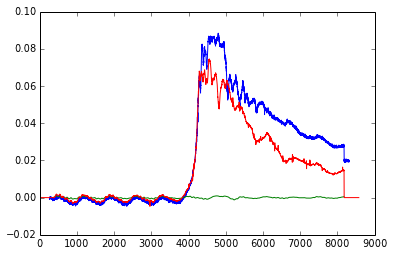

In [115]:
plt.plot(r.U[ex] - new_waves[0, 50])
plt.plot(more_waves[0, 50])
#plt.plot(even_more_waves[0, 50])
#plt.plot(mean_sub_u_n[0, 50])
plt.plot((trans_new_mean)[0, 50])


<matplotlib.contour.QuadContourSet instance at 0x1ef462d8>

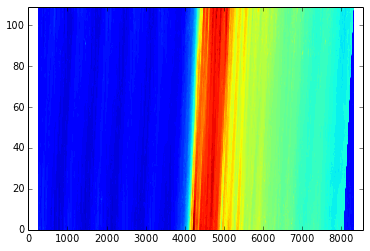

In [107]:
plt.contourf((trans_new_mean - varying_current)[20, :, :], 100)

### Other methods

There are two further ways of extracting the wave signal:

1. Find a vertical level that is unaffected by the gravity current
   and extract a full time series from this level.

2. Use the pre-current ambient to isolate a partial signal and
   extrapolate to the remainder of the time series.

In some runs the current is deep and method 1 is not practical. We
therefore need to extrapolate the time series.

In [3]:
# extract velocities up to point of current onset and take the mean
# over x and z
laminar_slice = np.s_[:, :, 250:2500]
u = r.U[laminar_slice]
v = r.V[laminar_slice]
w = r.W[laminar_slice]

t = r.T[laminar_slice][0, 0]

mean_u = np.mean(np.mean(u, axis=0), axis=0)
mean_v = np.mean(np.mean(v, axis=0), axis=0)
mean_w = np.mean(np.mean(w, axis=0), axis=0)

# basic 20-point (5hz) smoothing
window = np.hanning(20)
smooth_u = np.convolve(mean_u, window / window.sum(), mode='same')
smooth_v = np.convolve(mean_v, window / window.sum(), mode='same')
smooth_w = np.convolve(mean_w, window / window.sum(), mode='same')

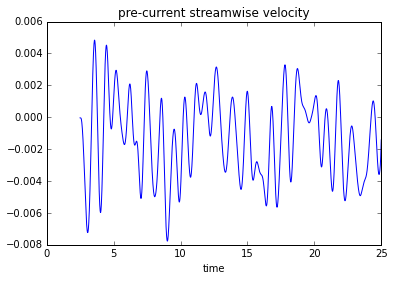

In [4]:
plt.plot(t, smooth_u, label='u')
plt.xlabel('time')
title = plt.title('pre-current streamwise velocity')

We want to extrapolate the time series `smooth_u`. A matlab method
is [here][dsp_stackexchange]. We use an auto-regressive method to
extrapolate the time series by using a linear model, assuming each
point is a linear combination of previous points.

[dsp_stackexchange]: http://dsp.stackexchange.com/questions/101/how-
do-i-extrapolate-a-1d-signal

In [5]:
from spectrum import arburg

n = 500  # order of AR model
p = 500  # number of samples in extrapolation
m = 150  # point at which to start prediction

AR_coeffs, AR_noisevariance, AR_reflection_coeffs = arburg(smooth_u, order=500)

extrapolated_u = np.hstack([smooth_u, np.zeros(p)])

# filter data 
sig.lfilter()

ImportError: No module named spectrum

Rotation correction
-------------------

This points us towards an additional correction to be applied to the
velocities. Linear surface waves should be homogeneous in the
vertical and cross stream axes due to the symmetry of the system.
That is, outside of turbulent flow, we should not have any variation
in $v$, the cross stream component of velocity.

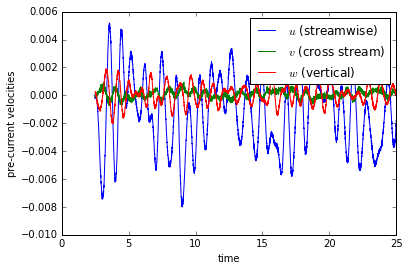

In [6]:
plt.plot(t, mean_u, label=r'$u$ (streamwise)')
plt.plot(t, mean_v, label=r'$v$ (cross stream)')
plt.plot(t, mean_w, label=r'$w$ (vertical)')
plt.xlabel('time')
plt.ylabel('pre-current velocities')
plt.legend()

We can see that the $u$ and $v$ components are zero at the same
time and that they move in anti-phase, suggesting that the laser
light sheet is tilted in these axes. The $w$ component does not show
covariance beyond what we might expect for deep water waves, so we
can assume that the light sheet is vertical.

It is possible that the correction is not linear and that it varies
with the velocity, however we can implement a simple first order
correction with this difference.

We can compute the optimal (by least squares) rotation matrix that
maps between two sets of points using SVD via the [Kabsch algorithm][kabsch].

[kabsch]: http://en.wikipedia.org/wiki/Kabsch_algorithm

[](igl.ethz.ch/projects/ARAP/svd_rot.pdf)
Challis, J.H. (1995). A procedure for determining rigid body transformation
parameters. J. Biomechanics 28, 733-737.
Umeyama, Shinji 1991, Least Squares Estimation of transformation parameters
between two point patterns.
[](http://nghiaho.com/?page_id=671)

In [9]:
import scipy.linalg as linalg

# vector of recorded points (2xn)
vec = np.vstack((smooth_u.flat, smooth_v.flat))

# real cross stream should be zero
# conserve speed to find real streamwise
mod_u = np.hypot(smooth_u, smooth_v)
ur = np.sign(smooth_u) * np.sign(smooth_v) * mod_u
vr = np.zeros(ur.shape)

# vector of real points (2xn)
vecr = np.vstack((ur.flat, vr.flat))

# mean subtract
vec_ = vec - np.mean(vec, axis=1, keepdims=True)
vecr_ = vecr - np.mean(vecr, axis=1, keepdims=True)

# now do least squares minimisation through SVD to find the rotation
# matrix R, vecr = R vec

# svd of the covariance matrix
U, W, Vh = linalg.svd(np.dot(vec_, vecr_.T))
d = linalg.det(np.dot(Vh.T, U.T))

S = np.ones(W.size)
S[-1] = d

R = np.dot(Vh.T, S * U.T)
theta = np.arccos(R[0, 0])

print R
print theta

[[ 0.99603533 -0.08895854]
 [ 0.08895854  0.99603533]]
0.0890762886332
